In [ ]:
#Input Images: Grayscale images
#S1: Gabor filter, conversion to spike-wave tensor
#C1: Local pooling
#S2: Trainable convolutional layer with STDP

In [1]:
#list of 4 Gabor filter kernels
import SpykeTorch.utils as utils

kernels = [	utils.GaborKernel(window_size = 3, orientation = 45+22.5),
			utils.GaborKernel(3, 90+22.5),
			utils.GaborKernel(3, 135+22.5),
			utils.GaborKernel(3, 180+22.5)]
filter = utils.Filter(kernels, use_abs = True)

In [2]:
#add a new dimension to the tensor (unsqueeze)
def time_dim(input):
	return input.unsqueeze(0)

In [3]:
#Grayscale and Tensor conversion are provided by Torchvision, implement lateral inhibition among features, object generates the spike-wave tensor based on intensities
import SpykeTorch.utils as utils
import SpykeTorch.functional as sf
import torchvision.transforms as transforms

transform = transforms.Compose(
	[transforms.Grayscale(),
	transforms.ToTensor(),
	time_dim,
	filter,
	sf.pointwise_inhibition,
	utils.Intensity2Latency(number_of_spike_bins = 15, to_spike = True)])

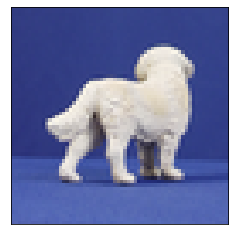

In [4]:
#create the data base object, upload database with 2 categories: dog, cup
#WITHOUT TRANSFORMATION
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random

dataset = ImageFolder("dataset/eth")
sample_idx = random.randint(0, len(dataset) - 1)

# plotting the sample image
ax = plt.subplot(1,1,1)
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[sample_idx][0])
plt.show()

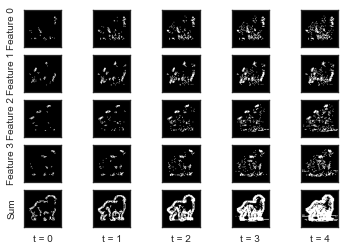

In [5]:
#WITH TRANSFORMATION
import numpy as np

dataset = ImageFolder("dataset/eth", transform) # adding transform to the dataset
plt.style.use('seaborn-white')
plt_idx = 0
sw = dataset[sample_idx][0]
for f in range(4):
	for t in range(5):
		plt_idx += 1
		ax = plt.subplot(5, 5, plt_idx)
		plt.setp(ax, xticklabels=[])
		plt.setp(ax, yticklabels=[])
		if t == 0:
			ax.set_ylabel('Feature ' + str(f))
		plt.imshow(sw[t,f].numpy(),cmap='gray')
		if f == 3:
			ax = plt.subplot(5, 5, plt_idx + 5)
			plt.setp(ax, xticklabels=[])
			plt.setp(ax, yticklabels=[])
			if t == 0:
				ax.set_ylabel('Sum')
			ax.set_xlabel('t = ' + str(t))
			plt.imshow(sw[t].sum(dim=0).numpy(),cmap='gray')
plt.show()

In [6]:
# splitting training and testing sets 
#75% training 25% testing
indices = list(range(len(dataset)))
random.shuffle(indices)
split_point = int(0.75*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]
print("Size of the training set:", len(train_indices))
print("Size of the  testing set:", len(test_indices))

Size of the training set: 615
Size of the  testing set: 205


In [7]:
# transform from image to spike-wave tensor is time-consuming, cache spike-wave tensors for each image
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

dataset = utils.CacheDataset(dataset)
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))

In [8]:
# layer C1 performs local pooling with window-size = 3 and stride = 2.
import SpykeTorch.snn as snn

pool = snn.Pooling(kernel_size = 3, stride = 2)

In [9]:
# create a convolutional layer with 20 features
# kernel-size equal to the size of the C1's output
# 64x64 input image shrinks to 62x62 after S1
# size of the C1's output will be 30x30
conv = snn.Convolution(in_channels=4, out_channels=20, kernel_size=30)

In [10]:
#assign STDP learning rule to layer S2
stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015))

In [11]:
#3.1 TRAINING
# input spikewave tensor passes through pooling (C1) and con. layers (S2)
# S2 denotes trajectory of potentials over all time-steps
# find the "winners" to perform plasticy based on earliest spike
# STDP applied to layer S2
print("Starting Unsupervised Training ...")
for iter in range(30):
	print('\rIteration:', iter, end="")
	for data,_ in train_loader:
		for x in data:
			x = pool(x)
			p = conv(x)
			o, p = sf.fire(p, 20, return_thresholded_potentials=True)
			winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
			stdp(x, p, o, winners)
print()
print("Unsupervised Training is Done.")

Starting Unsupervised Training ...
Iteration: 0

c:\users\vcosper\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 29
Unsupervised Training is Done.


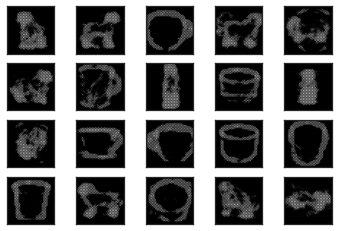

In [12]:
# reconstruct S2, receive features extracted by previous layer
import SpykeTorch.visualization as vis
import torch

feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (3, 3), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
for r in range(4):
    for c in range(5):
        ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()

In [13]:
# prep the training and testing data (network'd output vectors)
# S2: (1) potentials, (2) binary spikes
train_x_spike = []
train_x_pot = []
train_y = []
for data,targets in train_loader:
	for x,t in zip(data, targets):
		x = pool(x)
		p = conv(x)
		o = sf.fire(p, 20)
		train_x_spike.append(o.reshape(-1).cpu().numpy())
		train_x_pot.append(p.reshape(-1).cpu().numpy())
		train_y.append(t)
train_x_spike = np.array(train_x_spike)
train_x_pot = np.array(train_x_pot)
train_y = np.array(train_y)

In [14]:
# testing vectors
test_x_spike = []
test_x_pot = []
test_y = []
for data,targets in test_loader:
	for x,t in zip(data, targets):
		x = pool(x)
		p = conv(x)
		o = sf.fire(p, 20)
		test_x_spike.append(o.reshape(-1).cpu().numpy())
		test_x_pot.append(p.reshape(-1).cpu().numpy())
		test_y.append(t)
test_x_spike = np.array(test_x_spike)
test_x_pot = np.array(test_x_pot)
test_y = np.array(test_y)

In [17]:
# use external classifier for inference (SVM)
from sklearn.svm import LinearSVC

clf_spike = LinearSVC(max_iter=100000)
clf_pot = LinearSVC(max_iter=100000)
clf_spike.fit(train_x_spike, train_y)
clf_pot.fit(train_x_pot, train_y)

LinearSVC(max_iter=100000)

In [18]:
# inference
predict_spike = clf_spike.predict(test_x_spike)
predict_pot = clf_pot.predict(test_x_pot)

error_spike = np.abs(test_y - predict_spike).sum()
error_pot = np.abs(test_y - predict_pot).sum()
print("    Spike-based error:", error_spike/len(predict_spike))
print("Potential-based error:", error_pot/len(predict_pot))

    Spike-based error: 0.17073170731707318
Potential-based error: 0.0


In [19]:
# reinforcement learning
# train and evaluate layer S2
# reset weights of S2
conv.reset_weight()
anti_stdp = snn.STDP(conv_layer = conv, learning_rate = (-0.05, 0.0005))

In [20]:
# map from each S2 to a category
#assign first 10 to "cup" and second 10 to "dog"
feature2class = [0] * 10 + [1] * 10
print(feature2class)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [21]:
print("Starting Reinforcement Learning ...")
for iter in range(20):
	print('\rIteration:', iter, end="")
	for data,targets in train_loader:
		for x,t in zip(data, targets):
			x = pool(x)
			p = conv(x)
			o, p = sf.fire(p, 20, return_thresholded_potentials=True)
			winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
			if len(winners) != 0:
				if feature2class[winners[0][0]] == t:
					stdp(x, p, o, winners)
				else:
					anti_stdp(x, p, o, winners)
print()
print("Reinforcement Learning is Done.")

Starting Reinforcement Learning ...
Iteration: 19
Reinforcement Learning is Done.


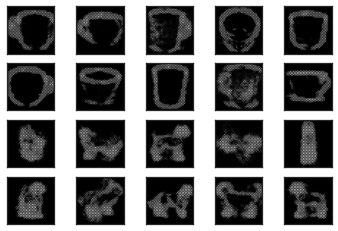

In [22]:
# reconstructing features
feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (3, 3), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
for r in range(4):
    for c in range(5):
        ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()

In [23]:
# check for errors
error = 0
silent = 0
total = 0
for data,targets in test_loader:
	for x,t in zip(data, targets):
		total += 1
		x = pool(x)
		p = conv(x)
		o, p = sf.fire(p, 20, return_thresholded_potentials=True)
		winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
		if len(winners) != 0:
			if feature2class[winners[0][0]] != t:
				error += 1
		else:
			silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)

         Error: 0.0
Silent Samples: 0.0
